In [1]:
import pandas as pd
import subprocess
import yaml
from tempfile import TemporaryFile
import pysam
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Annotate reads

In [4]:
infile = '/public/home/mowp/test/nanopore_cdna/basecalled_data/fhh.fastq.gz'
configure = 'config.yaml'
ref = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.isoform.fasta'
gff_path = '/public/home/mowp/db/Arabidopsis_thaliana/gff3/Arabidopsis_thaliana.TAIR10.46.gff3'
mm2thread = '40'

In [5]:
'''
将 basecalled read 与 araport11.isoform 比对，注释reads
'''
with TemporaryFile('w+t') as fp:
    # run minimap2
    proc = subprocess.run(
            ['minimap2', '-ax', 'map-ont', '-t', mm2thread, 
             '--secondary=no', ref, infile], stdout=fp)
    # Seek back to beginning
    fp.seek(0)
    samfile = pysam.AlignmentFile(fp, 'r')
    samdict = defaultdict(lambda: None)
    # filter unmapped read and keep the first result
    for read in samfile.fetch():
        if read.flag !=4 and read.query_name not in samdict:
             samdict[read.query_name] = read.reference_name

In [9]:
# mo result
polyacaller_result = '/public/home/mowp/test/fast5_api/fhh.polyacaller.tsv'
df = pd.read_csv(polyacaller_result, sep='\t')

In [10]:
df['transcript_id'] = df['read_id'].map(lambda x: samdict[x])

In [11]:
df['gene_id'] = df['transcript_id'].map(lambda x: x.split('.')[0] if x else None)

In [14]:
df

,read_id,read_type,tail_start,tail_end,samples_per_nt,tail_length,transcript_id,gene_id
0,761d15e0-3001-4569-857a-c0d271fcde63,polyT,1186,1266,10.255459,93.803704,AT1G15200.3,AT1G15200
1,827e58b8-ae39-4a46-8276-c484f7c3f416,polyA,6278,7046,9.959459,78.116689,AT4G10340.1,AT4G10340
2,d6f03b40-4b62-4196-b2c6-88c863a15dcd,polyA,5124,5534,8.652591,48.540373,AT1G70780.1,AT1G70780
3,8f17be18-c50e-4ab5-b431-87eb8236e483,polyA,13838,13846,9.690323,184.307590,AT5G18040.1,AT5G18040
4,b3c040ac-39b4-4c53-a9f0-4c0e05ca46eb,polyT,1316,2314,9.929329,102.323132,AT3G60245.1,AT3G60245
...,...,...,...,...,...,...,...,...
5709012,5b5d4055-8c20-4a54-ab6a-5bf12f6c2462,polyT,1292,2476,9.206349,131.213793,AT1G34380.2,AT1G34380
5709013,6a85f4ef-dbc2-4ea5-97ad-311afcc8aab3,polyT,902,1642,8.966154,84.317090,AT1G30380.1,AT1G30380
5709014,c98ef2e5-8473-4345-8426-61c9da686d9b,polyA,15710,16262,10.410385,389.034594,AT1G13440.1,AT1G13440
5709015,fd7bbc52-6683-4b85-a148-3f20650adec4,polyA,14658,15366,8.905473,100.387709,AT4G24220.1,AT4G24220


In [22]:
df[df.isnull().values==True]

,read_id,read_type,tail_start,tail_end,samples_per_nt,tail_length,transcript_id,gene_id
206,4d6c098a-e098-423a-a315-6c45a3b51b28,polyA,2334,2706,9.648069,88.722420,None,None
206,4d6c098a-e098-423a-a315-6c45a3b51b28,polyA,2334,2706,9.648069,88.722420,None,None
238,558d297a-c033-4663-9696-525c96f2946e,polyT,2288,2924,10.660920,61.533154,None,None
238,558d297a-c033-4663-9696-525c96f2946e,polyT,2288,2924,10.660920,61.533154,None,None
482,2906fc63-1f54-4a89-8b59-d2c090c0b52b,polyT,1034,2158,10.646067,106.518206,None,None
...,...,...,...,...,...,...,...,...
5708549,15fd8df1-6ed4-4327-ac3c-199eb5fb137e,polyT,1038,1040,9.765182,2.457711,None,None
5708663,42e51210-0bbc-40d5-a534-c23c37e89d68,polyA,5180,6306,9.484848,122.300319,None,None
5708663,42e51210-0bbc-40d5-a534-c23c37e89d68,polyA,5180,6306,9.484848,122.300319,None,None
5708883,e4740ef4-1bbb-487e-b409-58c5e85dfa1f,polyA,5584,6610,9.314410,111.440225,None,None


# polyA result summary

In [13]:
df.to_csv('fhh.polyacaller.ann.tsv', sep='\t', index=False)

In [15]:
gene_count = df['gene_id'].value_counts()
gene_count

AT1G67090    108054
AT1G29930     66416
AT5G38410     52652
AT5G24780     31752
AT2G38540     31700
              ...  
AT1G02550         1
AT2G29160         1
AT2G09380         1
AT2G29820         1
AT1G04257         1
Name: gene_id, Length: 24817, dtype: int64

In [16]:
tail_median_length = df.groupby(['gene_id']).median()['tail_length']

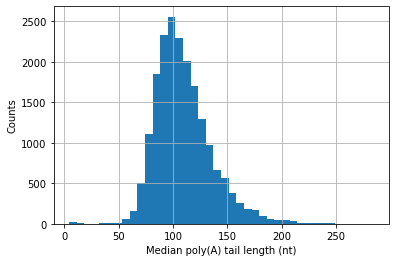

In [17]:
# 每个基因的polyA长度分布
tail_median_length[gene_count>=10].hist(bins=40)
plt.xlabel('Median poly(A) tail length (nt)')
plt.ylabel('Counts')
plt.show()

In [18]:
tail_median_length[gene_count>=10].median()

105.36617829166664

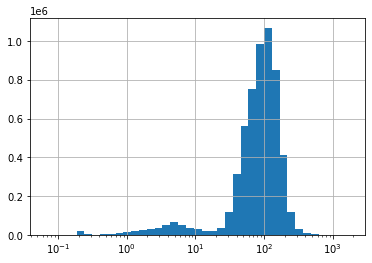

In [19]:
# 所有reads的polyA长度分布
MIN=df['tail_length'].min()
MAX=df['tail_length'].max()
df['tail_length'].hist(bins=10**np.linspace(np.log10(MIN), np.log10(MAX), 40))
plt.xscale('log')
plt.show()

# Parse GFF3 file

In [17]:
def parse_attribute(attr):
    '''get gene_id from attribute
    '''
    for item in attr.split(';'):
        key, value = item.split('=')
        if key == 'ID':
            return value.replace('gene:', '')
        
def get_gene_is_reverse():
    GFF_COLUMNS = ['seqid', 'source', 'type', 'start', 'end', 
                   'score', 'strand', 'phase', 'attribute']
    gff_df = pd.read_csv(gff_path, sep='\t', comment='#', names=GFF_COLUMNS)
    # keep type = 'gene'
    gff_df = gff_df[gff_df['type'].isin(['gene'])]
    # get gene_id
    gff_df['gene_id'] = gff_df['attribute'].map(parse_attribute)
    gff_df['is_reverse'] = gff_df['strand'].map(lambda x: False if x=='+' else True)
    
    return gff_df.set_index('gene_id')['is_reverse'].T.to_dict()

In [18]:
gene_is_reverse_dict = get_gene_is_reverse()

/public/home/mowp/miniconda3/envs/nano/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [19]:
gene_is_reverse_dict['AT1G15200']

True